In [1]:
## fine tuning SAM

In [1]:
from mb_llm.segsam2 import DataProcessor,ModelTrainer

/home/malav/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data = DataProcessor.load_data('./example_data/full_path_data.csv')
data[0]

{'image': '/home/malav/Downloads/datasets/pp_dataset/data_to_test/images/0000.png',
 'annotation': '/home/malav/Downloads/datasets/pp_dataset/data_to_test/mask/0000_mask.png'}

In [3]:
model = ModelTrainer('/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt','./sam2_hiera_s.yaml',device='cpu')

In [ ]:
model_updated = model.train(data,epochs=10,lr=0.0001,save_step=10,save_all=False)

/home/malav/.local/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Iteration 0, Segmentation Loss: 0.9954955577850342, Score Loss: 0.7144908308982849, Mean IOU: 0.0005113419517874718
Iteration 1, Segmentation Loss: 0.4028744697570801, Score Loss: 0.1700405478477478, Mean IOU: 0.005016760553792119
Iteration 2, Segmentation Loss: 1.8368974924087524, Score Loss: 0.2581098675727844, Mean IOU: 0.005197994384285063
Iteration 3, Segmentation Loss: 2.1810338497161865, Score Loss: 0.9035978317260742, Mean IOU: 0.00556316112318147
Iteration 4, Segmentation Loss: 0.11838623136281967, Score Loss: 0.3160756230354309, Mean IOU: 0.015426098242303964
Iteration 5, Segmentation Loss: 0.11404267698526382, Score Loss: 0.6487679481506348, Mean IOU: 0.02437670424138727
Iteration 6, Segmentation Loss: 0.1507493555545807, Score Loss: 0.6887997984886169, Mean IOU: 0.026776189214087226
Iteration 7, Segmentation Loss: 0.25357988476753235, Score Loss: 0.5465538501739502, Mean IOU: 0.02975382632020685
Iteration 8, Segmentation Loss: 0.5068294405937195, Score Loss: 0.3681003451347

In [1]:
## fine tuning sam2

In [1]:
from mb_annotation.segsam2 import load_data,sam_predictor,train_model

/home/malav/.local/lib/python3.11/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
data = load_data("/home/malav/Downloads/datasets/pp_dataset/data_to_test/full_path_data.csv")
data[0]

{'image': '/home/malav/Downloads/datasets/pp_dataset/data_to_test/images/0000.png',
 'annotation': '/home/malav/Downloads/datasets/pp_dataset/data_to_test/mask/0000_mask.png'}

In [3]:
predictor = sam_predictor('/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt','./sam2_hiera_s.yaml',device='cpu')

In [4]:
new_predictor = train_model(data, predictor, epochs=200, lr=1e-6,device='cpu',save_step=50,all=True)

step:0 loss:4.8661 seg_loss:4.8561 score_loss:0.2003 mean_iou:0.0002
step:1 loss:3.3160 seg_loss:3.2740 score_loss:0.8390 mean_iou:0.0004
step:2 loss:2.0014 seg_loss:1.9917 score_loss:0.1927 mean_iou:0.0004
step:3 loss:0.0147 seg_loss:0.0144 score_loss:0.0055 mean_iou:0.0103
step:4 loss:0.6305 seg_loss:0.6216 score_loss:0.1794 mean_iou:0.0122
step:5 loss:2.7636 seg_loss:2.7328 score_loss:0.6149 mean_iou:0.0125
step:6 loss:2.0500 seg_loss:2.0494 score_loss:0.0133 mean_iou:0.0125
step:7 loss:1.9046 seg_loss:1.8645 score_loss:0.8014 mean_iou:0.0141
step:8 loss:1.1871 seg_loss:1.1514 score_loss:0.7146 mean_iou:0.0141
step:9 loss:0.5154 seg_loss:0.5131 score_loss:0.0456 mean_iou:0.0151
step:10 loss:1.2696 seg_loss:1.2692 score_loss:0.0074 mean_iou:0.0150
step:11 loss:4.2407 seg_loss:4.2082 score_loss:0.6499 mean_iou:0.0148
step:12 loss:3.2489 seg_loss:3.2045 score_loss:0.8870 mean_iou:0.0155
step:13 loss:5.5605 seg_loss:5.5217 score_loss:0.7756 mean_iou:0.0154
step:14 loss:3.0154 seg_loss:3

In [16]:
import torch

sam2_checkpoint = "/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt"
model_cfg = "./sam2_hiera_s.yaml" # "sam2_hiera_l.yaml"

predictor = sam_predictor( sam2_checkpoint, model_cfg,device="cpu")
# predictor.model.load_state_dict(torch.load("./sam_model_checkpoints/sam_model_6.pt"))

In [5]:
import cv2
import numpy as np
def read_image(image_path, mask_path): # read and resize image and mask
        img = cv2.imread(image_path)[...,::-1]  # read image
        mask = cv2.imread(mask_path,0)
        r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
        img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
        mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
        return img, mask


def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)

In [6]:
import pandas as pd

t1 = pd.read_csv("/home/malav/Downloads/datasets/pp_dataset/data_to_test/full_path_data.csv")
t1.head(2)

,Unnamed: 0.1,Unnamed: 0,labels,bbox,image_path,mask_path,food_bbox
0,0,0,Pumpkin seed rolls,"[58.0, 0.0, 1142.0, 1496.0]",/home/malav/Downloads/datasets/pp_dataset/data...,/home/malav/Downloads/datasets/pp_dataset/data...,"[827, 196, 1282, 1007]"
1,1,1,Three-grain rolls,"[0.0, 0.0, 1200.0, 1600.0]",/home/malav/Downloads/datasets/pp_dataset/data...,/home/malav/Downloads/datasets/pp_dataset/data...,"[192, 119, 1055, 976]"


In [60]:
# # read image and sample points
# image,mask = read_image('/home/winnow/Desktop/data_to_test/images/0007.png','/home/winnow/Desktop/data_to_test/mask/0007_mask.png')
# input_points = get_points(mask,3)
# input_labels = np.ones([len(input_points),1])

value = 119
image = cv2.imread(t1['image_path'].iloc[value])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
bbox = eval((t1['food_bbox'].iloc[value]))
bbox_np = np.array(bbox,dtype=np.float32)
bbox_np

array([ 327.,  282., 1308.,  958.], dtype=float32)

In [8]:
from mb_annotation.segsam2 import *

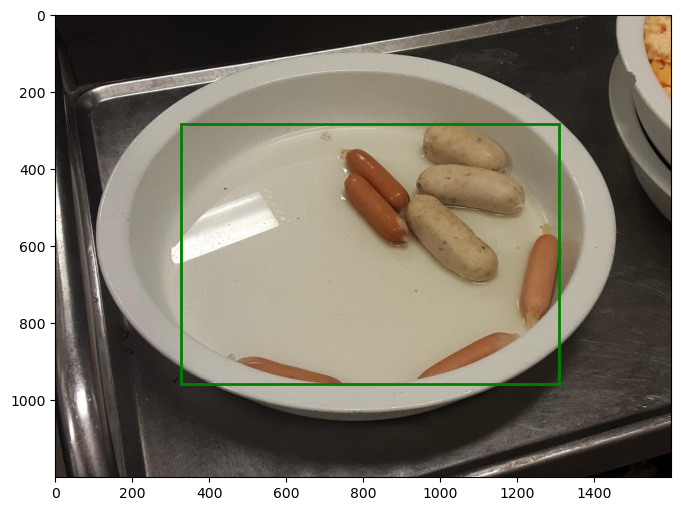

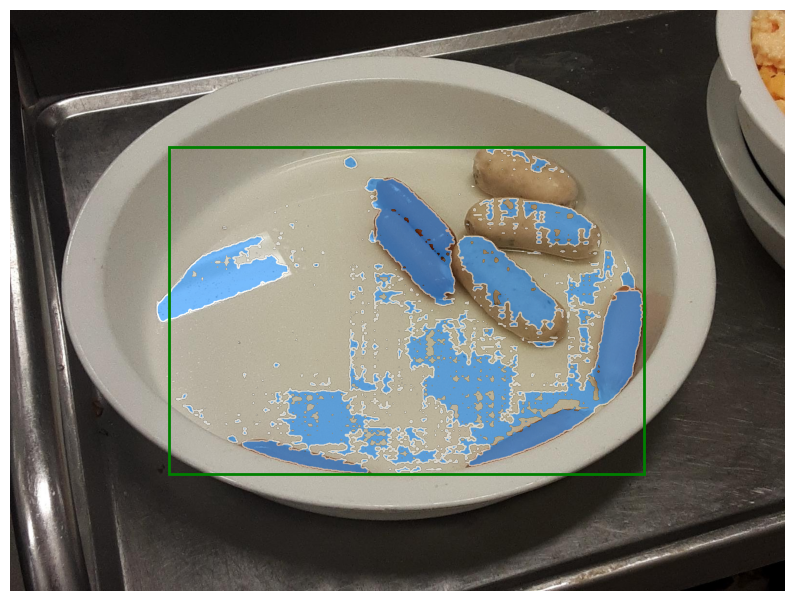

In [61]:
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
        new_predictor.set_image(image)
        masks, scores, logits = new_predictor.predict(
            box=bbox_np,multimask_output=False)
        
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        plt.figure(figsize=(9, 6))
        plt.imshow(image)

        if bbox is not None:
            show_box(bbox, plt.gca())

        show_masks_image(image, masks, scores, box_coords=bbox)

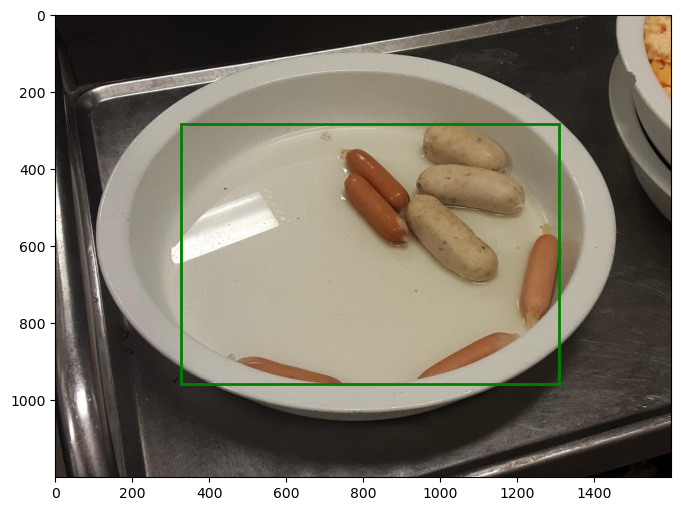

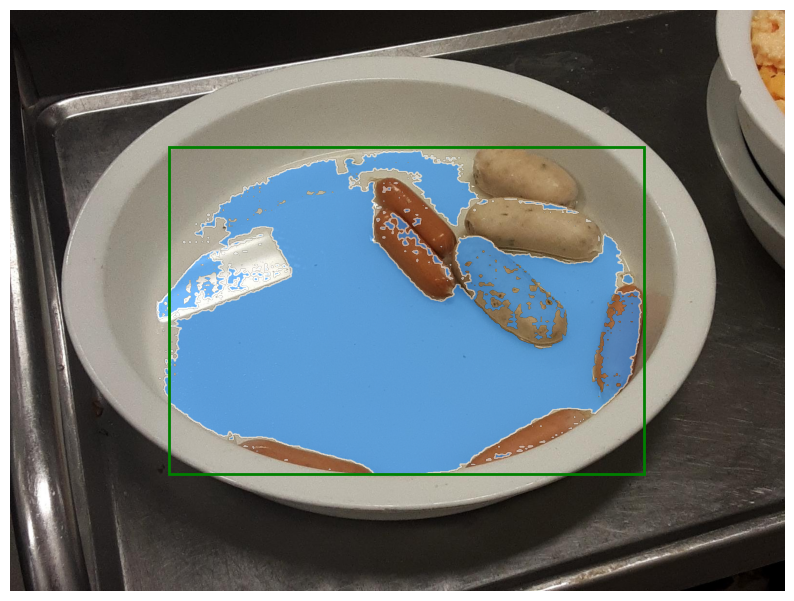

In [62]:

with torch.no_grad():
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(box=bbox, multimask_output=False)
        
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        plt.figure(figsize=(9, 6))
        plt.imshow(image)

        if bbox is not None:
            show_box(bbox, plt.gca())

        show_masks_image(image, masks, scores, box_coords=bbox)